# Trees for indexing

In this lab you will explore how trees may be utilized for indexing of vector data.

In [45]:
from sklearn.neighbors import BallTree, KDTree
import matplotlib.pyplot as plt

In [46]:
import random
import numpy as np

def generate(N, dim, steps=10):
    res = np.zeros((N, dim))
    bins = steps ** dim
    for i in range(N):
        cell = random.randrange(bins)
        for d in range(dim):
            idx = (cell // steps ** d) % steps
            res[i, d] = idx / steps + random.random() / steps
    return res

## Get a dataset

This code will generate and plot a dataset of 30K 2D points, uniformely distributed in 1x1 square.

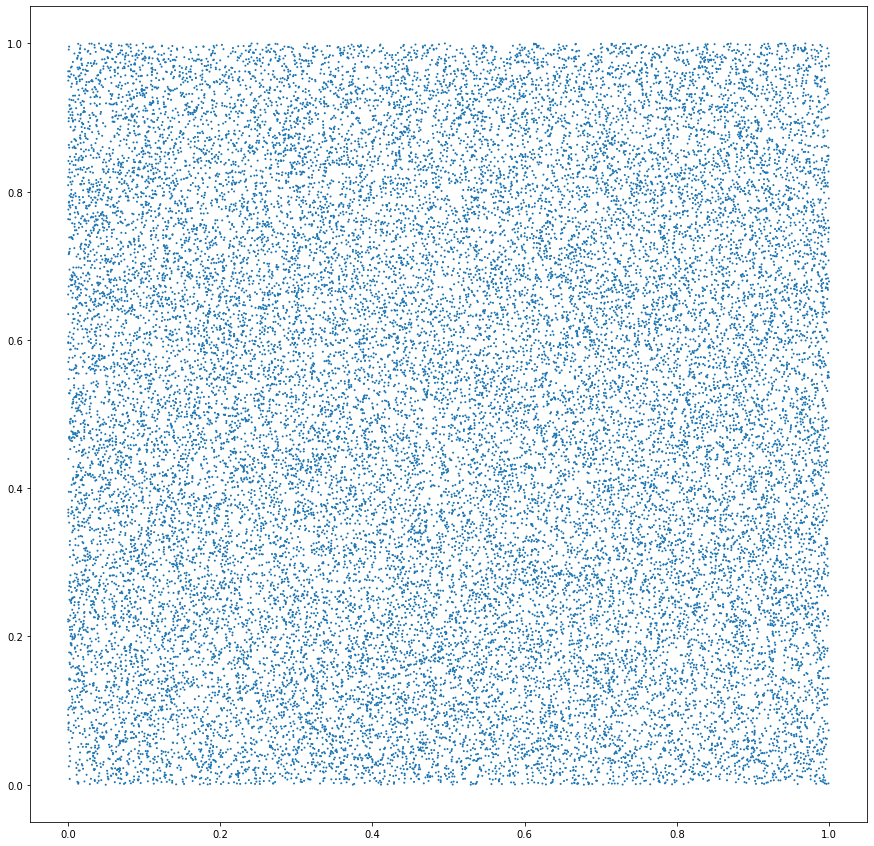

In [47]:
data2d = generate(30000, 2)
plt.figure(figsize=(15, 15))
plt.scatter(data2d[:, 0], data2d[:, 1], s=[1] * data2d.shape[0])

# Build 4 tree indices: KDTree, BallTree, [VPTree](https://pypi.org/project/vptree/), and Annoy

Simple case. We use 2D points and Euclidean distance as a similarity metric.

In [48]:
!pip install annoy vptree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
from annoy import AnnoyIndex
from vptree import VPTree
import time
import numpy as np

This is a query bucket for perpformance testing:

In [50]:
bucket2d = generate(200, 2)

### Prepare ground truth

For this bucket we find exact nearest neighbour indices in `GT` list of lists.

In [51]:
from scipy.spatial.distance import euclidean
from tqdm import tqdm


def get_GT(data, bucket):
    gt = []
    for i, row_b in enumerate(tqdm(bucket)):
        d = []
        for j, row_d in enumerate(data):
            d.append(euclidean(row_b, row_d))
        gt.append(np.argsort(d)[:1000])
    return gt

GT = get_GT(data2d, bucket2d)

100%|██████████| 200/200 [00:49<00:00,  4.06it/s]


## Formula for Recall@N

In [52]:
def recall(i1, i2, N=1000):
    return len(set(i1).intersection(i2)) / N

## Assessing KD Tree

### Build

In [53]:
start = time.time()
kdtree = KDTree(data2d)
print(f"KDTree is ready in {time.time() - start :.5f} s")

KDTree is ready in 0.01744 s


### Sample query

(3000, 2)


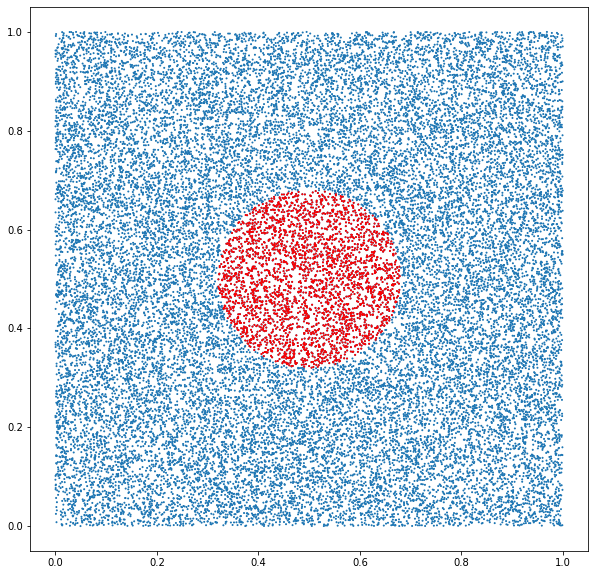

In [54]:
idx = kdtree.query([(.5, .5)], 3000, return_distance=False)[0]
points = data2d[idx, :]
print(points.shape)
plt.figure(figsize=(10, 10))
plt.scatter(data2d[:, 0], data2d[:, 1], s=[1] * data2d.shape[0])
plt.scatter(points[:, 0], points[:, 1], s=[1] * points.shape[0], color='red')
# TODO scatter the points array (search result) on the background of data 

### Bucket time and recall

In [55]:
start = time.time()
r = kdtree.query(bucket2d, 1000, return_distance=False)
print(f"Queries done in {time.time() - start :.5f} s")
rec = sum([recall(GT[i], r[i]) for i in range(len(bucket2d))]) / len(bucket2d)
print(f"Recall@1000 = {rec:.4f}")

Queries done in 0.06425 s
Recall@1000 = 1.0000


## Assessing Ball Tree

### Build

In [56]:
start = time.time()
balltree = BallTree(data2d)
print(f"BallTree is ready in {time.time() - start :.5f} s")

BallTree is ready in 0.01991 s


### Sample query

(3000, 2)


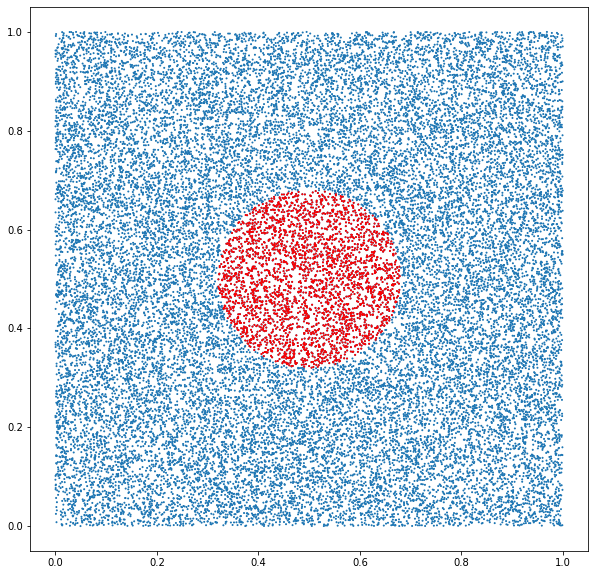

In [57]:
idx = balltree.query([(.5, .5)], 3000, return_distance=False)[0]
points = data2d[idx, :]
print(points.shape)
plt.figure(figsize=(10, 10))
plt.scatter(data2d[:, 0], data2d[:, 1], s=[1] * data2d.shape[0])
plt.scatter(points[:, 0], points[:, 1], s=[1] * points.shape[0], color='red')
# plot like this

### Bucket time and recall

In [58]:
start = time.time()
r = balltree.query(bucket2d, 1000, return_distance=False)
print(f"Queries done in {time.time() - start :.5f} s")
rec = sum([recall(GT[i], r[i]) for i in range(len(bucket2d))]) / len(bucket2d)
print(f"Recall@1000 = {rec:.4f}")

Queries done in 0.06602 s
Recall@1000 = 1.0000


## Assessing Annoy

### A single tree

In [59]:
start = time.time()
annoy1 = AnnoyIndex(data2d.shape[1], 'euclidean')
for i,v in enumerate(data2d):
  annoy1.add_item(i, v)
annoy1.build(1, n_jobs=-1)
print(f"Annoy is ready in {time.time() - start:.5} s")

Annoy is ready in 0.10471 s


### Sample query with 1 tree

(3000, 2)


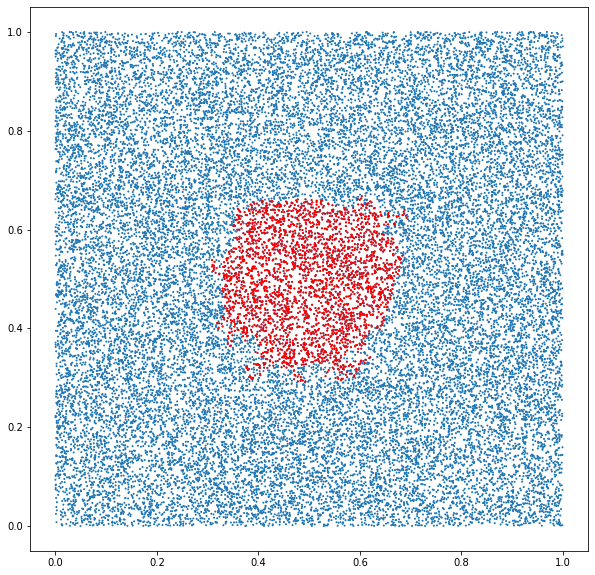

In [60]:
idx = annoy1.get_nns_by_vector([.5, .5], 3000)
points = data2d[idx, :]
print(points.shape)
plt.figure(figsize=(10, 10))
plt.scatter(data2d[:, 0], data2d[:, 1], s=[1] * data2d.shape[0])
plt.scatter(points[:, 0], points[:, 1], s=[1] * points.shape[0], color='red')
# plot

### Time and recall with 1 annoy tree

In [61]:
start = time.time()
r = [annoy1.get_nns_by_vector(q, 1000) for q in bucket2d]
print(f"Queries done in {time.time() - start :.5f} s")
rec = sum([recall(GT[i], r[i]) for i in range(len(bucket2d))]) / len(bucket2d)
print(f"Recall@1000 = {rec:.4f}")

Queries done in 0.06238 s
Recall@1000 = 0.9171


### Assessing Annoy multiple trees

Annoy is ready in 0.19953 s
(3000, 2)


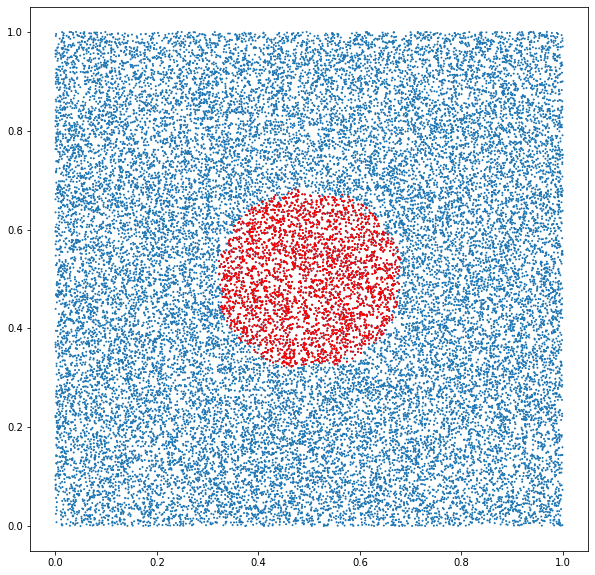

In [62]:
start = time.time()
annoy3 = AnnoyIndex(data2d.shape[1], 'euclidean')
for i,v in enumerate(data2d):
  annoy3.add_item(i, v)
annoy3.build(3, n_jobs=-1)
print(f"Annoy is ready in {time.time() - start:.5} s")

idx = annoy3.get_nns_by_vector([.5, .5], 3000)
points = data2d[idx, :]
print(points.shape)
plt.figure(figsize=(10, 10))
plt.scatter(data2d[:, 0], data2d[:, 1], s=[1] * data2d.shape[0])
plt.scatter(points[:, 0], points[:, 1], s=[1] * points.shape[0], color='red')
# plot

### Time and recall for multiple annoy trees

In [63]:
start = time.time()
r = [annoy3.get_nns_by_vector(q, 1000) for q in bucket2d]
print(f"Queries done in {time.time() - start :.5f} s")
rec = sum([recall(GT[i], r[i]) for i in range(len(bucket2d))]) / len(bucket2d)
print(f"Recall@1000 = {rec:.4f}")

Queries done in 0.13291 s
Recall@1000 = 0.9792


### Assessing Vantage Point Tree

In [64]:
start = time.time()
vptree = VPTree(list(enumerate(data2d)), lambda x, y: euclidean(x[1], y[1]))
print(f"VPTree is ready in {time.time() - start :.5f} s")

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


VPTree is ready in 7.16814 s


In [65]:
# idx = [x[1][0] for x in vptree.get_n_nearest_neighbors([.5, .5], 3000)]
# points = data2d[idx, :]
# print(points.shape)
# plt.figure(figsize=(10, 10))
# plt.scatter(data2d[:, 0], data2d[:, 1], s=[1] * data2d.shape[0])
# plt.scatter(points[:, 0], points[:, 1], s=[1] * points.shape[0], color='red')
# # plot

In [66]:
# start = time.time()
# r = [[x[1][0] for x in vptree.get_n_nearest_neighbors(q, 1000)] for q in bucket2d]
# print(f"Queries done in {time.time() - start :.5f} s")
# rec = sum([recall(GT[i], r[i]) for i in range(len(bucket2d))]) / len(bucket2d)
# # print([recall(GT[i], r[i]) for i in range(len(bucket2d))])
# print(f"Recall@1000 = {rec:.4f}")

Vantage Point tree: what is the reason to be soo slow? Is there any reason to trust python libraries?

# Trees scalability testing

We will vary `D` parameter which corresponds for the data dimensionality. We expect that with higher dimensions our trees should loose speed as well as recall.

`VPTree` left the contest due to unacceptable speed. We test KDTree, BallTree, Annoy with 20 trees, and Annoy with 100 trees.

In [67]:
statistics = {"D":[], "tree":[], "construction":[], "search":[], "recall":[]}

for D in [2, 5, 10, 15, 50, 100, 200]:
    data = generate(50000, D)
    bucket = generate(50, D)
    
    myGT = get_GT(data, bucket)
    
    ###################################
    print(f"kdtree {D}")
    start = time.time()
    kdtree = KDTree(data)
    statistics["D"].append(D)
    statistics["tree"].append("kdtree")
    statistics["construction"].append(time.time() - start)
    start = time.time()
    r = kdtree.query(bucket, 1000, return_distance=False)
    statistics["search"].append(time.time() - start)
    rec = sum([recall(myGT[i], r[i]) for i in range(len(bucket))]) / len(bucket)
    statistics["recall"].append(rec)
    ###################################
    
    ###################################
    print(f"balltree {D}")
    start = time.time()
    balltree = BallTree(data)
    statistics["D"].append(D)
    statistics["tree"].append("balltree")
    statistics["construction"].append(time.time() - start)
    start = time.time()
    r = balltree.query(bucket, 1000, return_distance=False)
    statistics["search"].append(time.time() - start)
    rec = sum([recall(myGT[i], r[i]) for i in range(len(bucket))]) / len(bucket)
    statistics["recall"].append(rec)
    ###################################
    
    ###################################
    print(f"annoy-20 {D}")
    statistics["D"].append(D)
    statistics["tree"].append("annoy20")

    start = time.time()
    annoy20 = AnnoyIndex(data.shape[1], 'euclidean')
    for i, v in enumerate(data):
        annoy20.add_item(i, v)
    annoy20.build(20, n_jobs=-1)
    statistics["construction"].append(time.time() - start)
    start = time.time()
    r  = [annoy20.get_nns_by_vector(q, 1000) for q in bucket]
    statistics["search"].append(time.time() - start)
    rec = sum([recall(myGT[i], r[i]) for i in range(len(bucket))]) / len(bucket)
    statistics["recall"].append(rec)
    ###################################
    
    
    ###################################
    print(f"annoy-100 {D}")
    statistics["D"].append(D)
    statistics["tree"].append("annoy100")

    start = time.time()
    annoy100 = AnnoyIndex(data.shape[1], 'euclidean')
    for i, v in enumerate(data):
        annoy100.add_item(i, v)
    annoy100.build(100, n_jobs=-1)
    statistics["construction"].append(time.time() - start)
    start = time.time()
    r  = [annoy100.get_nns_by_vector(q, 1000) for q in bucket]
    statistics["search"].append(time.time() - start)
    rec = sum([recall(myGT[i], r[i]) for i in range(len(bucket))]) / len(bucket)
    statistics["recall"].append(rec)
    ###################################

100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


kdtree 2
balltree 2
annoy-20 2
annoy-100 2


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


kdtree 5
balltree 5
annoy-20 5
annoy-100 5


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


kdtree 10
balltree 10
annoy-20 10
annoy-100 10


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


kdtree 15
balltree 15
annoy-20 15
annoy-100 15


100%|██████████| 50/50 [00:17<00:00,  2.78it/s]


kdtree 50
balltree 50
annoy-20 50
annoy-100 50


100%|██████████| 50/50 [00:17<00:00,  2.80it/s]


kdtree 100
balltree 100
annoy-20 100
annoy-100 100


100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


kdtree 200
balltree 200
annoy-20 200
annoy-100 200


In [68]:
import pandas as pd
df = pd.DataFrame(statistics)
df

D      tree  construction    search   recall
0     2    kdtree      0.020846  0.009144  1.00000
1     2  balltree      0.019684  0.011441  1.00000
2     2   annoy20      1.475752  0.143240  0.99980
3     2  annoy100      7.501790  0.912876  1.00000
4     5    kdtree      0.041543  0.019412  1.00000
5     5  balltree      0.032704  0.025754  1.00000
6     5   annoy20      1.125693  0.138233  0.99996
7     5  annoy100      6.116949  0.642387  1.00000
8    10    kdtree      0.074228  0.071758  1.00000
9    10  balltree      0.050758  0.064376  1.00000
10   10   annoy20      0.855742  0.137146  0.99504
11   10  annoy100      4.641229  0.788477  0.99998
12   15    kdtree      0.114354  0.133717  1.00000
13   15  balltree      0.072990  0.112614  1.00000
14   15   annoy20      1.088827  0.155937  0.97560
15   15  annoy100      4.179647  0.579777  0.99998
16   50    kdtree      0.464315  0.551524  1.00000
17   50  balltree      0.378774  0.492885  1.00000
18   50   annoy20      0.694166  0.114476  0.78402
19   50  annoy100      2.596787  0.493893  0.99820
20  100    kdtree      0.878776  0.799135  1.00000
21  100  balltree      0.699399  0.702145  1.00000
22  100   annoy20      1.095048  0.158514  0.64906
23  100  annoy100      4.054369  0.527024  0.99240
24  200    kdtree      2.065675  1.426750  1.00000
25  200  balltree      1.547532  1.210650  1.00000
26  200   annoy20      1.759272  0.191350  0.54680
27  200  annoy100      5.569264  0.542616  0.97648

## Graphs analysis

Look at the graphs. Discuss, which data structure you will choose, and for which task?

- For Computer Graphics and Geospacial data?
- For text embedding?
- With volatile data?
- With stable data?
- In Web search?
- In library search?

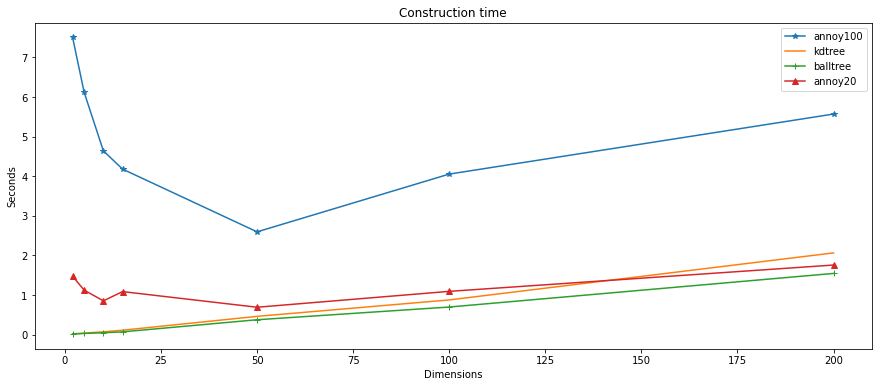

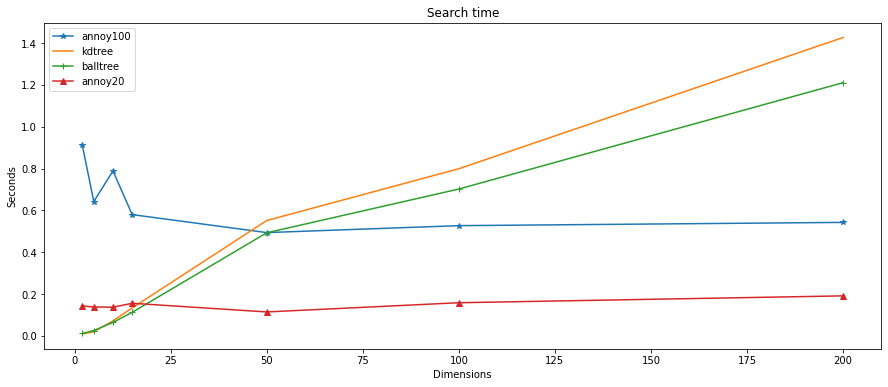

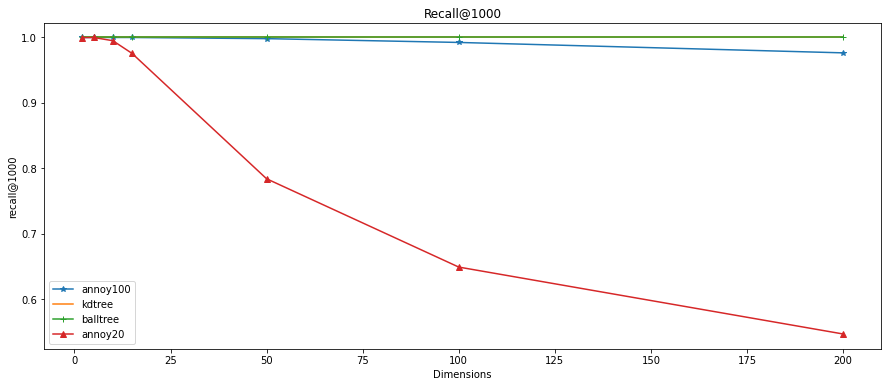

In [69]:
types = set(df['tree'])
markers = dict(zip(types, ["*", "", "+", "^"]))

plt.figure(figsize=(15, 6))
plt.title("Construction time")
for typ in types:
    x = df[df['tree'] == typ]['D']
    y = df[df['tree'] == typ]['construction']
    plt.plot(x, y, label=typ, marker=markers[typ])
plt.xlabel("Dimensions")
plt.ylabel("Seconds")
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.title("Search time")
for typ in types:
    x = df[df['tree'] == typ]['D']
    y = df[df['tree'] == typ]['search']
    plt.plot(x, y, label=typ, marker=markers[typ])
plt.ylabel("Seconds")
plt.xlabel("Dimensions")
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.title("Recall@1000")
for typ in types:
    x = df[df['tree'] == typ]['D']
    y = df[df['tree'] == typ]['recall']
    plt.plot(x, y, label=typ, marker=markers[typ])
plt.xlabel("Dimensions")
plt.ylabel("recall@1000")
plt.legend()
plt.show()

# 3. Questions to discuss

1. Should we trust `pip`-based implementations? If no, how to validate?
2. What should be the strategy to choose index structure for your data? Take dimensions, size, implementations into account.
3. We measured 3 numbers, representing data structures. Can we consider anything else? Open http://ann-benchmarks.com/ and see, what they care about.
4. Is there anything missing in their benchmarks?

# 4. Advanced problem

What will change in the picture, if you change `euclidean` metric with `cosine`? Can you implement this?